In [27]:
import gseapy as gp
import pandas as pd
import numpy as np
import scipy.stats as stats
import glob
from biomart import BiomartServer
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import gseapy as gp

from sklearn import decomposition
from sklearn import preprocessing

from scripts import aesthetics

aesthetics.activate_paper_rcParams()

pd.set_option("display.max_columns", 1000)

# Neuroblastoma CWAS RNA

Alright, here's the other arm of this analysis that we'd like to pursue. I want to examine the expression of genes potentially affected by SVs in these categories from Riaz's CWAS analysis.

We have expression data for a subset of the neuroblastoma cases. The idea of this analysis is to answer the following question:

`Are the significant categories reflected in increases of expression in their target genes?`

Doing this is a bit tricky, and we'll need to derive an appropriate framework. One key difficulty is that we have _no idea_ of the underlying purity or characteristics of these RNA samples. As a result, directly comparing expression values is difficult. But we'll try our best.

# Load our data

Since we'll be doing a category analysis, we have to load basically all our data.

## Read in SVs

In [2]:
# define SVs and dosages
sv_path = "gs://vanallen-pedsv-analysis/beds/PedSV.v2.5.2.full_cohort.analysis_samples.sites.bed.gz"
dosages_path = "gs://vanallen-pedsv-analysis/beds/PedSV.v2.5.2.full_cohort.analysis_samples.allele_dosages.bed.gz"

# define metadata
metadata_path = "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.2.cohort_metadata.w_control_assignments.tsv.gz"
samples_path = "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.2.final_analysis_cohort.samples.list"

Load metadata and SVs

In [3]:
metadata = pd.read_csv(
    metadata_path,
    sep="\t",
)

# add a sex label to metadata
metadata["sex"] = (metadata["chrX_CopyNumber"].round() < 2).astype(int)

Now we load the SVs. We combine discovery and validation, although I'm pretty sure our TPM subset is only one of those.

In [4]:
###############
##### SVs #####
###############
svs = pd.read_csv(
    sv_path,
    sep="\t",
)

###############
### Dosages ###
###############
dosages = pd.read_csv(
    dosages_path,
    sep="\t",
    index_col=False,
)

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (10,34,35,37,39,41,45,46,47,48,72,73,87,88,106,107,121,122,136,137,155,156,170,171,185,186,204,205,219,220,234,235,253,254,268,269,283,284,302,303,366,367,381,382,400,401,415,416,430,431,449,450,464,465,479,480,498,499,513,514,528,529,547,548,562,563,577,578,596,597,645,646,647,648,649,650,690,691,692,693,694,695,713,714,728,729,743,744,758,759,773,774,788,789,803,804,818,819,833,834,848,849,863,864,878,879,893,894,908,909,923,924,931,937,943) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Read in the category results

I'm going to concatenate all this data so that I'm only dealing with a few files. Focusing on neuroblastoma.

In [340]:
###########
### SVs ###
###########
nbl_coding_svs = pd.read_csv(
    "data/CWAS data for Jett/List of variants by category for each CWAS analysis/neuroblastoma_all_coding_SVs_in_each_category_list_combined_11_3_23.txt",
    sep="\t",
)

nbl_noncoding_svs = pd.read_csv('data/CWAS data for Jett/List of variants by category for each CWAS analysis/neuroblastoma_all_noncoding_SVs_in_each_category_list_combined_BURDEN_TESTING_with_col_names_11_3_23.txt', sep='\t')
nbl_noncoding_svs = nbl_noncoding_svs.rename(columns = {'emd': 'end'})

# combine the SVs
nbl_coding_svs['sv_category'] = 'coding'
nbl_noncoding_svs['sv_category'] = 'non-coding'

nbl_category_svs = pd.concat([nbl_coding_svs, nbl_noncoding_svs])
nbl_category_svs.head(2)

,SV,chrom,start,end,category,sv_category
0,PedSV.2.5.2_DUP_chr1_794,chr1,19221626,19301822,DUP.RARE.PREDICTED_COPY_GAIN.lof_constrained.e...,coding
1,PedSV.2.5.2_DUP_chr1_1379,chr1,44731601,44792024,DUP.RARE.PREDICTED_COPY_GAIN.lof_constrained.e...,coding


In [341]:
#########################
### FRAMEWORK RESULTS ###
#########################
nbl_singleton_coding_framework_results = pd.read_csv(
    "data/CWAS data for Jett/CWAS sum stats/neuroblastoma_all_coding_cwas_concatenated_glm_results_SINGLETON_11_3_23.txt",
    sep="\t",
)
nbl_singleton_coding_framework_results[['af_category', 'sv_category']] = ['singleton', 'coding']

nbl_rare_coding_framework_results = pd.read_csv(
    "data/CWAS data for Jett/CWAS sum stats/neuroblastoma_all_coding_cwas_concatenated_glm_results_RARE_11_3_23.txt",
    sep="\t",
)
nbl_rare_coding_framework_results[['af_category', 'sv_category']] = ['rare', 'coding']

nbl_singleton_noncoding_framework_results = pd.read_csv(
    "data/CWAS data for Jett/CWAS sum stats/neuroblastoma_all_noncoding_cwas_concatenated_glm_results_SINGLETON_11_3_23.txt",
    sep="\t",
)
nbl_singleton_noncoding_framework_results[['af_category', 'sv_category']] = ['singleton', 'non-coding']

nbl_rare_noncoding_framework_results = pd.read_csv(
    "data/CWAS data for Jett/CWAS sum stats/neuroblastoma_all_noncoding_cwas_concatenated_glm_results_RARE_11_3_23.txt",
    sep="\t",
)
nbl_rare_noncoding_framework_results[['af_category', 'sv_category']] = ['rare', 'non-coding']

nbl_framework_results = pd.concat([nbl_singleton_coding_framework_results, nbl_rare_coding_framework_results, 
                                   nbl_singleton_noncoding_framework_results, nbl_rare_noncoding_framework_results])

In [342]:
nbl_framework_results.head(2)

,point_estimate,std_error,z_score,p_value,SV_counts_cases,SV_counts_cases_max,number_of_cases_with_zero_SVs,total_cases,SV_counts_controls,SV_counts_controls_max,number_of_controls_with_zero_SVs,total_controls,number_of_unique_SVs,category_name,sv_type,frequency,mean_SVs_per_case,mean_SVs_per_control,mean_SVs_total,negative_log10_p_value,af_category,sv_category
0,0.271918,0.051227,5.308100,1.110000e-07,438,5,336,646,2441,4,2848,4700,459,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,ANY,SINGLETON,0.678019,0.519362,0.538533,6.955563,singleton,coding
1,0.276065,0.054006,5.111756,3.190000e-07,393,5,356,646,2172,4,3012,4700,411,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,DEL,SINGLETON,0.608359,0.462128,0.479798,6.495968,singleton,coding


In [343]:
nbl_coding_framework = pd.read_csv(
    "data/CWAS data for Jett/CWAS frameworks/CWAS_categories_neuroblastoma_coding_8_17_23.txt",
    sep="\t",
)

nbl_noncoding_framework = pd.read_csv(
    "data/CWAS data for Jett/CWAS frameworks/CWAS_rare_categories_neuroblastoma_noncoding_10_2_23.txt",
    sep="\t",
)

## Read in TPMs

Load our TPMs. We'll briefly take a look at the manifest file first.

In [57]:
manifest = pd.read_csv('data/CWAS data for Jett/GMKF_Neuroblastoma_Germline_Structural_Variant_Analysis_RSEM_expression_files/GMKF_neuroblastoma_transcriptomic_data_manifest_rsem_gene_files_2_22_22.txt', sep='\t')
manifest = manifest.dropna(subset = manifest.columns, how = 'all')
manifest.head(2)

,id,name,file_name_simplified,size,project,ethnicity,gender,race,vital_status,sample_id,sample_type,platform,age_at_diagnosis,tumor_location,aliquot_id,library_id,histology,composition,reference_genome,species,case_id,data_type,investigation,experimental_strategy
0,62140522c087b02cb6535584,4452cf2b-df37-439b-92d0-7e3853c50eee.rsem.gene...,4452cf2b-df37-439b-92d0-7e3853c50eee,2503209.0,rgillani/gmkf-neuroblastoma-transcriptomic-data,Not Hispanic or Latino,Female,Reported Unknown,Alive,BS_5W25GMQ1,Tumor,Illumina,1295.0,Reported Unknown,575765.0,GMKF-30-PATMDE03-01B-99R,"Ganglioneuroblastoma, intermixed",Solid Tissue,GRCh38,Homo sapiens,PT_4A1B95TK,Gene Expression,Discovering the Genetic Basis of Human Neurobl...,RNA-Seq
1,62140522c087b02cb6535578,7e31540e-112f-439a-9562-ad760bb6d5c5.rsem.gene...,7e31540e-112f-439a-9562-ad760bb6d5c5,2488632.0,rgillani/gmkf-neuroblastoma-transcriptomic-data,Not Hispanic or Latino,Male,White,Alive,BS_5Y7PNW71,Tumor,Illumina,1712.0,Reported Unknown,575872.0,GMKF-30-PAVKZC03-01A-01R,"Ganglioneuroblastoma, nodular",Solid Tissue,GRCh38,Homo sapiens,PT_GSWXPFPQ,Gene Expression,Discovering the Genetic Basis of Human Neurobl...,RNA-Seq


In [58]:
manifest.shape

(209, 24)

Not very useful at all, but it does give us a way to map file names to sample names.

In [59]:
file_to_sample = dict(zip(manifest['name'], manifest['case_id']))

In [60]:
merged_tpms = []
merged_counts = []
for file in glob.glob('data/CWAS data for Jett/GMKF_Neuroblastoma_Germline_Structural_Variant_Analysis_RSEM_expression_files/*.rsem.genes.tsv'):
    file_name = file.split('/')[-1][:-3] + 'results.gz'
    
    sample = file_to_sample[file_name]

    data = pd.read_csv(file, sep = '\t')
    data['sample'] = sample
    merged_tpms.append(data[['sample', 'gene_id', 'TPM']])
    merged_counts.append(data[['sample', 'gene_id', 'expected_count']])
    
merged_tpms = pd.concat(merged_tpms)
merged_tpms = merged_tpms.pivot(index = "gene_id", columns = 'sample', values = 'TPM').reset_index()

merged_counts = pd.concat(merged_counts)
merged_counts = merged_counts.pivot(index = "gene_id", columns = 'sample', values = 'expected_count').reset_index()

In [61]:
for d in [merged_tpms, merged_counts]:
    d.insert(1, 'ENSEMBL_ID', d['gene_id'].apply(lambda x: x.split('.')[0]))
    d.insert(2, 'gene_symbol', d['gene_id'].apply(lambda x: x.split('_')[-1]))

In [62]:
merged_tpms.to_csv('data/merged_neuroblastoma_tpms.tsv', sep = '\t', index = False)
merged_counts.to_csv('data/merged_neuroblastoma_counts.tsv', sep = '\t', index = False)

In [63]:
merged_tpms.head(2)

sample,gene_id,ENSEMBL_ID,gene_symbol,PT_02SNWVRF,PT_0XAWD5CE,PT_10KTTTPD,PT_11XN6CG5,PT_1396H6SD,PT_1EQHANKW,PT_1MWZEHCT,PT_1NDSW1JX,PT_1RH3DTPB,PT_1X6CJ589,PT_1X9YQF9W,PT_1YAJEAMJ,PT_21PJ8R0Z,PT_22BQQFYM,PT_26E4RFYV,PT_2AZNEYG9,PT_2DX56CE0,PT_2FB9C15K,PT_2G290D0G,PT_2HCWZNTR,PT_2JZNQGTR,PT_2M970JK9,PT_2QB9MP9J,PT_2RZN4HR2,PT_2Y7Q85BM,PT_2YBKT6RW,PT_3VNMNFT6,PT_3WF5J3PZ,PT_3YW2V4JK,PT_49FZV0HC,PT_4A1B95TK,PT_4FTZAAC4,PT_4W8PD8TR,PT_4WVGKQRX,PT_4Y3P2N1P,PT_53M7K3JE,PT_56ZM694R,PT_581CW7RN,PT_58J0PB4V,PT_5CPS8GNT,PT_5E269C8Z,PT_5FCYBT0S,PT_5MA1YQ49,PT_5W51TAZS,PT_64B8K70Y,PT_66Y5KGME,PT_69AGBVQ5,PT_69EVASRX,PT_6DHGCDRP,PT_6HZH56MX,PT_6M0TPG4X,PT_6R3RJ6MY,PT_6TM0T48Z,PT_6WE8JADD,PT_70BK6DFW,PT_7APMD0HG,PT_7BAFX5PZ,PT_7E6A5N3P,PT_7XV9SBKQ,PT_81RSHW1D,PT_82D2FJV2,PT_86NG4W76,PT_89D6BFGP,PT_8BYCCC0V,PT_8DFBAQVQ,PT_8HFHWZH9,PT_8RQQWAQR,PT_92RR9C8D,PT_9A9Q2YB3,PT_9DD8F0VD,PT_9GRB7EF0,PT_9K8VF0Z0,PT_9KB3ESTZ,PT_9NMNEV0Y,PT_9QQ37AWW,PT_9RJY3GWC,PT_9X3MV3GW,PT_A4VM4H5N,PT_A77B7F2F,PT_AGYJR7PZ,PT_APMAKP20,PT_AQS8CCAB,PT_ASH4P45D,PT_ASJZTDRF,PT_ATQMV6B3,PT_B0YZ0H85,PT_B39849MF,PT_B9CP3H35,PT_B9X3H54Y,PT_BZCXTAH9,PT_BZZY1BM4,PT_C32MGZSB,PT_C3YC0C9Q,PT_C6429DZZ,PT_CCC65GCE,PT_CV0FE3Z3,PT_D4SZQV48,PT_D508JGWE,PT_D5BYDHZ9,PT_D9XF79J4,PT_DCBZYQAX,PT_DP679T4D,PT_DS5XN67S,PT_E3R0MRXN,PT_E6CZS2KF,PT_E7PFZT6E,PT_ECTDZ6QS,PT_EKP4F49T,PT_ESKA5P5B,PT_EXZSSRGH,PT_F0QD1YWQ,PT_F2AFSP66,PT_FW0K9SXK,PT_FZ3XEWEK,PT_G3Q35987,PT_GGJ9E0VV,PT_GQBEY0JD,PT_GSWXPFPQ,PT_GV2XJJTP,PT_H2Q0BW73,PT_H3GBG09Q,PT_HA7TBZ1V,PT_HB9JT4G5,PT_HC1QFR28,PT_HQ23GQ23,PT_HYJB8Y4N,PT_HZ4VWQP5,PT_HZQ6TWR9,PT_J3X9NQ5F,PT_JBQT2QPG,PT_JD8FVX6G,PT_JYRSHSWJ,PT_K0BJPWY9,PT_K3QMVST1,PT_K5709E5B,PT_K579G3KQ,PT_K59VNJ70,PT_KBT22K39,PT_KBVX8B37,PT_KH0H9EZS,PT_KRHMQFFP,PT_KWEJJM22,PT_KWRFGRER,PT_KX5R6KSM,PT_KXWQXAR4,PT_M4ETZ912,PT_M6QAJFS8,PT_M8RHAK5K,PT_MG3HP8D9,PT_MK375DCF,PT_NK39AFPG,PT_NYMKWAZT,PT_NZ3F3J67,PT_P111JVHP,PT_P2M0Q2KS,PT_P7V330C5,PT_P9QJMTF8,PT_PDYCQB6P,PT_PFRE83H3,PT_PV869ZYE,PT_Q50YZ2T5,PT_QCMS0C3W,PT_QF2A2F08,PT_QH23VVKW,PT_QW5Q0G84,PT_QZFYXPJK,PT_R07QYFJ0,PT_R94DDN50,PT_RG7MMHFF,PT_RJPEMEQV,PT_RMH6RJ1P,PT_RS3TBZV5,PT_RSPKGFXS,PT_RVTVP55V,PT_S4EJKTME,PT_SBS3N6ZT,PT_SDPQ63J1,PT_SV8ETF29,PT_TTHE7B08,PT_V1HR5C5P,PT_V3BXBVVV,PT_V65ESGCE,PT_VA8GM98Z,PT_VVVS471N,PT_W6AVZF18,PT_WG51EA8V,PT_WH6RANZQ,PT_WSQ011Z1,PT_WWQGABFP,PT_WWRAC6EH,PT_X8N7GE8X,PT_XDPN4357,PT_XKZYFJZV,PT_XNBJNRXJ,PT_XNDPC9TT,PT_XPGEBQKA,PT_XPTE7785,PT_YGW6KQHQ,PT_YHWENHB0,PT_YJ8KZG27,PT_YMDFCE4V,PT_YPK89ADE,PT_YS31MFW0,PT_YYGH8EMR,PT_Z4S0193A,PT_ZK8Z4WAK,PT_ZS5D8MVF,PT_ZT2NW6WA,PT_ZW22K0YF
0,ENSG00000000003.14_TSPAN6,ENSG00000000003,TSPAN6,3.61,7.62,4.30,2.15,5.05,9.24,4.71,5.88,1.38,4.27,2.02,3.36,3.17,7.48,5.85,10.18,0.0,3.53,6.71,3.07,6.36,3.53,3.48,3.11,2.27,5.29,5.13,8.56,8.71,6.89,5.84,6.03,4.88,3.21,4.91,5.69,5.14,3.42,5.52,3.64,9.19,4.50,4.14,8.18,4.75,6.09,2.19,1.03,5.56,7.46,4.38,16.69,5.32,2.22,3.48,12.82,3.93,5.42,5.33,15.09,6.02,7.87,6.65,8.35,7.13,6.33,3.32,16.37,5.19,7.46,4.49,16.05,7.10,11.59,3.77,7.35,15.50,3.45,2.43,2.27,1.93,2.85,8.17,3.3,11.01,6.02,3.75,9.38,12.32,6.57,4.12,1.08,4.35,5.62,6.61,5.42,5.80,8.86,6.82,2.15,8.82,4.54,2.85,5.47,6.03,5.99,4.87,3.6,3.61,13.90,4.05,3.34,5.47,10.79,4.32,4.17,6.61,4.58,4.77,28.44,3.00,5.50,3.37,2.47,5.95,5.51,9.22,2.67,6.49,5.25,6.79,9.47,3.72,7.45,5.42,2.37,8.00,4.01,7.13,2.59,4.60,7.1,4.46,3.52,4.06,7.82,11.20,4.77,1.33,5.72,6.19,8.68,2.80,1.63,8.07,8.86,2.94,6.56,3.98,4.65,3.64,5.25,2.78,3.71,2.12,11.43,5.96,16.48,3.31,5.27,6.14,4.64,0.0,19.99,4.49,4.63,4.94,4.78,2.71,7.94,7.36,2.39,3.04,2.21,3.59,4.35,7.1,12.48,2.59,5.76,4.59,9.73,4.56,14.11,3.07,12.56,13.63,5.41,2.94,3.57,2.71,3.73,5.58,8.16,4.73,13.37,3.1,10.42,9.68
1,ENSG00000000005.5_TNMD,ENSG00000000005,TNMD,0.03,0.00,0.05,0.00,0.11,0.00,0.07,0.02,0.09,0.12,0.02,0.02,0.00,0.00,0.03,0.03,0.0,0.00,0.00,0.02,0.07,0.02,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.04,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.10,0.00,0.00,0.00,0.00,0.00,0.07,0.00,0.00,0.16,0.00,0.15,0.00,0.06,0.00,0.00,0.

For the most part, we don't care about non-genes (e.g. lncRNA's, etc). There are definitely instances, however, where we might care about them.

Let's just create a separate dataset for coding analyses.

In [64]:
# Connect to the BioMart server and use the Ensembl dataset
server = BiomartServer("http://www.ensembl.org/biomart")
ensembl = server.datasets['hsapiens_gene_ensembl']

# Query the database to get the Ensembl gene IDs and HGNC symbols for genes with RefSeq mRNA annotations
response = ensembl.search({
    'filters': {'with_refseq_mrna': True},
    'attributes': ['ensembl_gene_id', 'hgnc_symbol']
})

# # Create a list of tuples from the response
data = [line.decode('utf-8').split('\t') for line in response.iter_lines()]

# Convert the list of tuples into a pandas DataFrame
genes_df = pd.DataFrame(data, columns = ['ensembl_gene_id', 'hgnc_symbol'])

# Display the DataFrame - the first few rows don't have gene names
genes_df.head(6)

,ensembl_gene_id,hgnc_symbol
0,ENSG00000271254,
1,ENSG00000277630,
2,ENSG00000274175,
3,ENSG00000275869,
4,ENSG00000276256,
5,ENSG00000281934,PRAMEF11


In [65]:
merged_tpms_protein_coding = merged_tpms.merge(genes_df, left_on = ['ENSEMBL_ID'], right_on = 'ensembl_gene_id', how = 'inner')
merged_tpms_protein_coding = merged_tpms_protein_coding.drop(columns = ['ensembl_gene_id', 'hgnc_symbol'])
merged_tpms_protein_coding.iloc[:, 3:] = np.divide(merged_tpms_protein_coding.iloc[:, 3:], merged_tpms_protein_coding.iloc[:, 3:].sum(axis = 0)) * 1e6

In [66]:
merged_tpms_protein_coding.to_csv('data/merged_neuroblastoma_coding_tpms.tsv', sep = '\t', index = False)

# Examine our TPMs

Our first step, naturally, is to examine our TPMs. There are a few questions we need to answer about this dataset.

First, how many samples are present?

## Sample characteristics

In [67]:
samples = list(merged_tpms.columns[3:])
len(samples)

209

And how many of these samples do we actually have SVs for?

In [68]:
len(set(metadata['entity:sample_id']) & set(samples))

158

Only 158... I assume that these samples were dropped for QC reasons.

In [69]:
metadata[metadata['entity:sample_id'].isin(samples)].groupby(['neuroblastoma_case']).size()

neuroblastoma_case
False    69
True     89
dtype: int64

So a large number of these samples were actually dropped from the case control analysis, presumably for sample specific reasons. Unfortunate.

In [70]:
included_samples = metadata[(metadata['entity:sample_id'].isin(samples)) &
                            (metadata['neuroblastoma_case'] == True)]['entity:sample_id'].tolist()
len(included_samples)

89

In [71]:
merged_tpms = merged_tpms[list(merged_tpms.columns[:3]) + included_samples]
merged_counts = merged_counts[list(merged_counts.columns[:3]) + included_samples]
merged_tpms_protein_coding = merged_tpms_protein_coding[list(merged_tpms_protein_coding.columns[:3]) + included_samples]

# TPM quality

It's pretty damn hard to assess the quality of RNA sequencing post-hoc, but we'll give it our best shot. We have 89 samples. I'd like to know some underlying features of this data.

The first thing we can do is just snoRNAs, which can be high in bad data.

## snoRNAs

Text(0, 0.5, 'density')

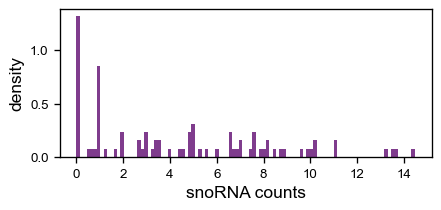

In [72]:
sno_rsem = merged_counts[merged_counts['gene_symbol'].str.contains('sno')].iloc[:, 3:]

# filter down to any sno "genes" that have nonzero reads in any samples
fig, ax = plt.subplots(1, figsize = (5, 2))
plt.hist(sno_rsem.loc[(sno_rsem != 0).any(axis = 1)].sum(axis = 0), bins = 100, density = True);
ax.set_xlabel('snoRNA counts')
ax.set_ylabel('density')

Some of those values are definitely a little higher than I'd like, but it is what it is. I don't know enough to create some filter.

## PCA plot

In [73]:
tpm_dict = {'log_1p': np.log1p(merged_tpms.iloc[:, 3:]),
            'log_1p_protein': np.log1p(merged_tpms_protein_coding.iloc[:, 3:])}

In [74]:
# normalize for PCA
pca_dict = {}
pca_models = {}
for label, matrix in tpm_dict.items():
    norm_matrix = preprocessing.StandardScaler().fit_transform(matrix.T)
    pca = decomposition.PCA(n_components=min(norm_matrix.shape[0] - 1, norm_matrix.shape[1]), random_state=0)
    
    # store the model
    pca_models[label] = pca
    
    # transform the data, then store the PC results
    pca_transformed_data = pca.fit_transform(norm_matrix)
    
    pca_tpm_df = pd.DataFrame(pca_transformed_data)
    pca_tpm_df.columns = ['PC' + str(i) for i in range(1, len(pca_tpm_df.columns) + 1)]
    pca_tpm_df.index = merged_tpms.columns[3:]
    
    pca_dict[label] = pca_tpm_df

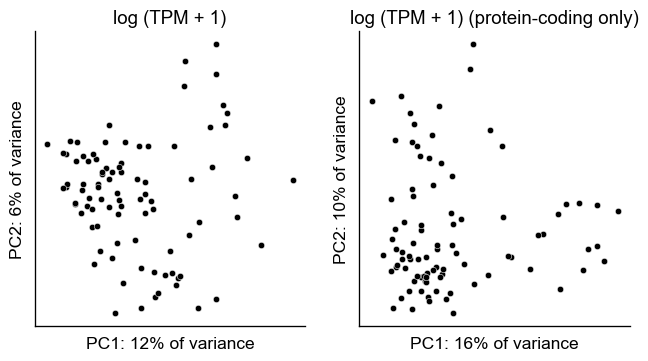

In [75]:
tpm_fig, tpm_axes = plt.subplots(1, 2, figsize = (8, 4))
for i, label in enumerate(['log_1p', 'log_1p_protein']):
    
    data = pca_dict[label][['PC1', 'PC2']].copy()
    
    # plot data
    sns.scatterplot(x = 'PC1', y = 'PC2', data = data, ax = tpm_axes[i], color = 'black')
    
    tpm_axes[i].set_xticklabels([])
    tpm_axes[i].set_yticklabels([])
    tpm_axes[i].tick_params(axis='both', which='both', length = 0)
    
    pca_results = pca_models[label]
    tpm_axes[i].set_xlabel('PC1: {:.0f}% of variance'.format(pca_results.explained_variance_ratio_[0]*100))
    tpm_axes[i].set_ylabel('PC2: {:.0f}% of variance'.format(pca_results.explained_variance_ratio_[1]*100))
    tpm_axes[i].set_title(['log (TPM + 1)', 'log (TPM + 1) (protein-coding only)', 'log (TPM + 1) (hvg)'][i])
    
    sns.despine(bottom = False, left = False)


Obviously, this tells us nothing up front.

## House keeping genes

Another metric we can use is the count of house-keeping genes.

In [76]:
housekeeping = ['ACTB', 'GAPDH', 'TBP', 'UBC', 'RPS18']
housekeeping_counts = merged_counts[merged_counts['gene_symbol'].isin(housekeeping)].set_index('gene_symbol').iloc[:, 2:]
housekeeping_counts_norm = stats.zscore(housekeeping_counts, axis = 1)

Let's plot these on a heatmap

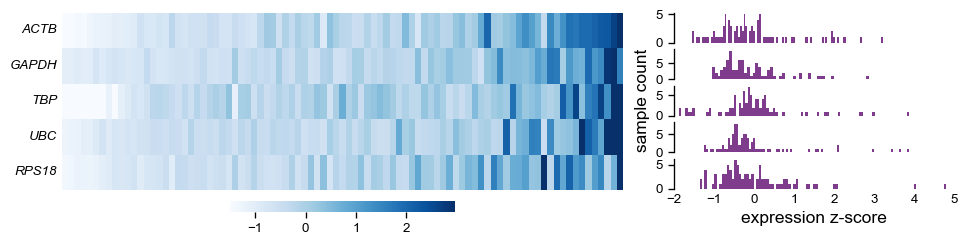

In [77]:
# define a rough order
sample_order = housekeeping_counts_norm.mean(axis = 0).sort_values().index

# make the figure and gridspec
fig = plt.figure(figsize=(12, 3))
gs = fig.add_gridspec(5, 2, width_ratios = [2, 1], wspace = 0.12)

# plot the heatmap
heatmap_ax = fig.add_subplot(gs[:, 0])

sns.heatmap(housekeeping_counts_norm.loc[:, sample_order], cmap="Blues", robust=True, 
            ax = heatmap_ax, cbar_kws={"orientation": "horizontal", "pad":0.05, 'shrink': 0.4})
heatmap_ax.set_yticklabels(housekeeping, rotation = 0, ha = 'right', fontstyle = 'italic')
heatmap_ax.tick_params(which = 'both', length = 0)
heatmap_ax.set_xticklabels([])
heatmap_ax.set_ylabel('')
heatmap_ax.set_xlabel('')

gene_gs = matplotlib.gridspec.GridSpecFromSubplotSpec(6, 1, gs[:, 1], height_ratios = [1] * 5 + [1.3])
for i, g in enumerate(housekeeping):
    ax = fig.add_subplot(gene_gs[i])
    ax.hist(housekeeping_counts_norm.loc[g, :], bins = 100)
    sns.despine(ax = ax, bottom = True)
    ax.set_xlim([-2, 5])
    if i != 4:
        ax.get_xaxis().set_visible(False)
        
    else:
        ax.tick_params(axis = 'x', length = 0)
        ax.set_xlabel('expression z-score')
        
    if i == 2:
        ax.set_ylabel('sample count')
        

We can try arbitrarily removing a subset of samples if they exceed 2.5 stds of housekeeping expression in 3 housekeeping genes.

In [78]:
percentiles = np.percentile(housekeeping_counts_norm, [95], axis = 1).reshape(-1, 1)
sample_filter = np.greater(housekeeping_counts_norm, percentiles)
removed_samples = sample_filter.loc[:, sample_filter.sum(axis = 0) >= 3]
removed_samples

sample,PT_6WE8JADD,PT_HB9JT4G5,PT_P111JVHP
gene_symbol,,,
ACTB,True,True,True
GAPDH,True,False,True
TBP,True,True,False
UBC,True,True,True
RPS18,False,True,False


In [79]:
removed_samples = removed_samples.columns

Out of curiosity, how does this look on a PCA plot?

In [80]:
housekeeping_mean = housekeeping_counts_norm.mean(axis = 0)

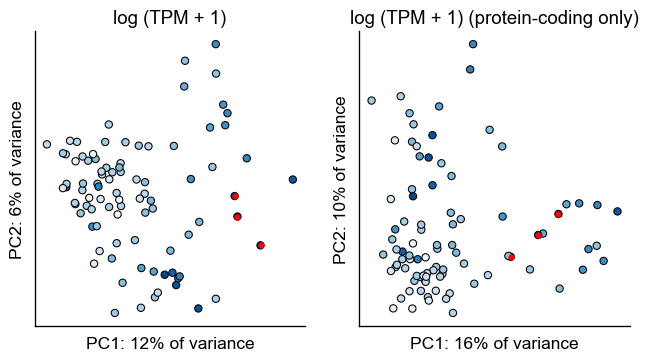

In [81]:
tpm_fig, tpm_axes = plt.subplots(1, 2, figsize = (8, 4))

norm = matplotlib.colors.Normalize(vmin=-1.5, vmax=2)
for i, label in enumerate(['log_1p', 'log_1p_protein']):
    
    data = pca_dict[label][['PC1', 'PC2']].copy()
    
    # add in housekeeping data
    data['housekeeping'] = housekeeping_mean.loc[data.index]
    
    # plot data
    points = tpm_axes[i].scatter(data['PC1'], data['PC2'], c=data['housekeeping'],
                                 cmap=plt.get_cmap('Blues'), norm = norm, edgecolor = 'black', s = 30)
    
    removed = data.loc[removed_samples]
    points = tpm_axes[i].scatter(removed['PC1'], removed['PC2'], c = 'red', edgecolor = None, s = 15)
    
    tpm_axes[i].set_xticklabels([])
    tpm_axes[i].set_yticklabels([])
    tpm_axes[i].tick_params(axis='both', which='both', length = 0)
    
    pca_results = pca_models[label]
    tpm_axes[i].set_xlabel('PC1: {:.0f}% of variance'.format(pca_results.explained_variance_ratio_[0]*100))
    tpm_axes[i].set_ylabel('PC2: {:.0f}% of variance'.format(pca_results.explained_variance_ratio_[1]*100))
    tpm_axes[i].set_title(['log (TPM + 1)', 'log (TPM + 1) (protein-coding only)', 'log (TPM + 1) (hvg)'][i])
    
    sns.despine(bottom = False, left = False)
    

I mean... meh, right? Clearly these samples are slight outliers, but I see no reason to believe they're extremely abnormal. I don't see a frank need to remove them. So we keep all 89 samples.

## Adrenal signature

One important component of this analysis is that we have no idea of the underlying purity of these samples. This could be a pretty big problem, as eventually we'll be ranking these samples by expression. If a subset of samples have consistently low purity and these genes are relevant in an adrenal context, then we could get skewed results.

One way to check this is to devise an expression signature that is derived from adrenal-specific genes. This could (theoretically) help us control for these effects downstream. Maybe.

In [82]:
adrenal_genes = pd.read_csv('ref/adrenal-specific-genes.txt', sep='\t', comment = '#')['Gene Name'].tolist()
print(adrenal_genes)

['CYP17A1', 'CHGB', 'CYP11B1', 'STAR', 'HSD3B2', 'AKR1B1', 'CYP21A2', 'NOV', 'FDX1', 'DBH', 'SOAT1', 'MGARP', 'TH', 'AS3MT', 'PNMT', 'VWA5B2', 'MCOLN3', 'ARHGAP36', 'CARTPT', 'CYP11B2', 'KCNK2', 'CHRNA3', 'MC2R', 'SLC18A1', 'MAP3K15', 'PHOX2A', 'RET', 'FAM19A4', 'AP000783.1', 'C18orf42', 'AC015660.1', 'PHOX2B', 'FAM43B', 'DRGX', 'UCP1']


In [83]:
merged_tpms_pc_gsea = merged_tpms_protein_coding.set_index('gene_symbol').iloc[:, 2:]
merged_tpms_pc_gsea.head(2)

,PT_02SNWVRF,PT_11XN6CG5,PT_1396H6SD,PT_1EQHANKW,PT_1RH3DTPB,PT_1X6CJ589,PT_1X9YQF9W,PT_21PJ8R0Z,PT_26E4RFYV,PT_2JZNQGTR,PT_2QB9MP9J,PT_2RZN4HR2,PT_2Y7Q85BM,PT_3VNMNFT6,PT_4Y3P2N1P,PT_56ZM694R,PT_5E269C8Z,PT_5FCYBT0S,PT_69AGBVQ5,PT_6DHGCDRP,PT_6WE8JADD,PT_70BK6DFW,PT_7APMD0HG,PT_7BAFX5PZ,PT_7E6A5N3P,PT_81RSHW1D,PT_82D2FJV2,PT_8DFBAQVQ,PT_9A9Q2YB3,PT_9QQ37AWW,PT_9X3MV3GW,PT_A77B7F2F,PT_AGYJR7PZ,PT_AQS8CCAB,PT_ASJZTDRF,PT_ATQMV6B3,PT_B39849MF,PT_C3YC0C9Q,PT_D5BYDHZ9,PT_DCBZYQAX,PT_E3R0MRXN,PT_E6CZS2KF,PT_EXZSSRGH,PT_F0QD1YWQ,PT_F2AFSP66,PT_FZ3XEWEK,PT_GGJ9E0VV,PT_GSWXPFPQ,PT_HA7TBZ1V,PT_HB9JT4G5,PT_HYJB8Y4N,PT_HZ4VWQP5,PT_JBQT2QPG,PT_JD8FVX6G,PT_JYRSHSWJ,PT_K0BJPWY9,PT_K3QMVST1,PT_K579G3KQ,PT_KBVX8B37,PT_M4ETZ912,PT_M8RHAK5K,PT_MK375DCF,PT_NK39AFPG,PT_P111JVHP,PT_PDYCQB6P,PT_PFRE83H3,PT_PV869ZYE,PT_Q50YZ2T5,PT_QF2A2F08,PT_QH23VVKW,PT_R94DDN50,PT_RVTVP55V,PT_SBS3N6ZT,PT_SDPQ63J1,PT_SV8ETF29,PT_TTHE7B08,PT_V3BXBVVV,PT_V65ESGCE,PT_VVVS471N,PT_W6AVZF18,PT_WWRAC6EH,PT_X8N7GE8X,PT_XPTE7785,PT_YGW6KQHQ,PT_YMDFCE4V,PT_YS31MFW0,PT_Z4S0193A,PT_ZK8Z4WAK,PT_ZT2NW6WA
gene_symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TSPAN6,13.371365,7.458475,16.812866,26.645397,4.260488,12.268498,12.030655,9.01669,22.009318,17.438509,12.494672,12.474228,5.98563,19.234141,12.572486,17.233388,28.389828,15.093672,6.492729,17.001738,7.982832,12.501859,36.167566,12.895066,21.734756,45.031394,18.754089,27.487045,17.248522,11.008326,40.932662,9.659539,8.078493,8.503080,9.462301,32.228893,12.300013,13.597521,22.357115,24.351058,18.937078,21.477597,35.373366,12.298143,15.968089,41.23376,14.762318,22.104827,19.800499,20.090890,16.490749,29.011792,15.849597,17.91214,26.242139,14.925513,20.689594,7.206234,19.938861,25.903271,17.608834,18.658268,18.877963,6.368619,16.580955,10.888372,15.481078,12.115863,8.410188,13.207728,48.682937,56.050621,16.449966,18.001097,15.550149,10.397539,22.228091,7.567005,9.337225,11.745586,15.903369,15.366313,42.228962,23.961827,10.793547,17.017862,16.736601,42.579061,27.269844
TNMD,0.111119,0.000000,0.366221,0.000000,0.277858,0.344782,0.119115,0.00000,0.112868,0.191933,0.143617,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.134166,0.000000,0.000000,0.000000,0.538873,0.000000,0.196871,0.000000,0.000000,0.124612,0.000000,0.232639,0.087599,0.369714,0.079502,0.000000,0.238683,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.101794,0.000000,0.095617,0.00000,0.000000,0.000000,6.192156,0.119234,0.448931,0.346128,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.295326,0.097858,0.426965,0.273499,0.000000,0.136789,0.000000,0.000000,0.000000,0.000000,0.000000,0.308433,0.000000,0.000000,0.422912,0.000000,0.000000,0.000000,0.000000,0.556198,0.000000,0.234345,0.000000,0.000000,0.000000,0.000000,0.106152,0.127387,0.000000


In [86]:
ss = gp.ssgsea(data=merged_tpms_pc_gsea,
                   gene_sets={'adrenal': adrenal_genes},
                   outdir=None,
                   sample_norm_method='rank',
                   no_plot=True,
                   min_size=4)

adrenal_signature = ss.res2d
adrenal_signature.columns = ['sample', 'signature', 'enrichment_score', 'normalized_enrichment_score']

2023-12-02 15:01:37,369 [WARNING] Found duplicated gene names, values averaged by gene names!


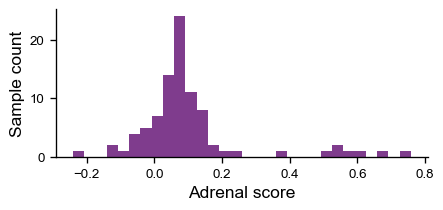

In [87]:
fig, ax = plt.subplots(1, figsize = (5, 2))
plt.hist(adrenal_signature['normalized_enrichment_score'], bins = 30);
ax.set_xlabel('Adrenal score')
ax.set_ylabel('Sample count')
sns.despine()

So there's definitely some variation there. This will be important to keep in mind.

## One last filter -- expression

Since we'll be comparing expression between different samples, we should remove genes that have extremely low expression. This is akin to the filtering that is done in DESeq. We'll only keep genes that have more than 10 counts in more than 5 samples.

In [418]:
kept_rows = (merged_counts[included_samples] >= 10).sum(axis = 1) >= 5
kept_gene_ids = merged_counts[kept_rows]['gene_id'].tolist()

# Framework for thinking about expression

Let's pause for a second and think about how we want to approach these data. Effectively in this process, we're going to end up with the following:

```
For each category
    for each SV
        for each gene affected by that SV (usually 1)
            expression values for each sample + whether that sample has the SV
```

It's easy enough to generate a rank from that list and identify the rank of samples with the SV compared to samples without the SV. But one of the underlying issues is directionality--if there is an effect of the SV, we have no way of knowing if it's up or down. 

One way to handle this is to use the absolute difference from the median, but this obfuscates differences within an individual sample. For now, let's just store the rank and see what happens.

# Try a coding example

This analysis is naturally most relevant for coding examples. Let's example the top coding hit:

In [441]:
nbl_coding_svs = pd.read_csv(
    "data/CWAS data for Jett/List of variants by category for each CWAS analysis/neuroblastoma_all_coding_SVs_in_each_category_list_combined_11_3_23.txt",
    sep="\t",
)

In [442]:
test_framework = nbl_framework_results.query('af_category == "singleton" & sv_category == "coding"').loc[0, ["category_name"]].item()
framework_components = test_framework.split(".")
genic_relationship = framework_components[2]
test_framework, genic_relationship

('ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding',
 'PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP')

So we need to do the following:

1. Identify the SVs that are part of this category
2. Identify the genes that are affected by these SVs
3. Quantify the expression in samples with the SV compared to samples without (will almost always be 1 vs. 88, or something like that)

We do this for all SVs in the category, and we can derive some summary metric.

In [443]:
svs_in_category = nbl_category_svs[(nbl_category_svs['sv_category'] == "coding") & 
                                   (nbl_category_svs["category"] == test_framework)]

# subset the actual SV matrix
svs_in_category = svs[svs["name"].isin(svs_in_category["SV"].tolist())]

svs_in_category.head(2)

,#chrom,start,end,name,svtype,AC,AF,ALGORITHMS,AN,BOTHSIDES_SUPPORT,CHR2,CNV_CONCORDANCE,CPX_INTERVALS,CPX_TYPE,END,END2,EVIDENCE,FAILED_COHORT_COMPARISONS,GENOTYPE_CONCORDANCE,HET_PPV,HET_SENSITIVITY,HG38_REF_PATCH_LOCUS,HIGH_SR_BACKGROUND,HOMVAR_PPV,HOMVAR_SENSITIVITY,MINSL,NCN,NCR,NCR_TMP,NON_REF_GENOTYPE_CONCORDANCE,OLD_ID,PCRMINUS_NCR,PESR_GT_OVERDISPERSION,PREDICTED_BREAKEND_EXONIC,PREDICTED_COPY_GAIN,PREDICTED_DUP_PARTIAL,PREDICTED_INTERGENIC,PREDICTED_INTRAGENIC_EXON_DUP,PREDICTED_INTRONIC,PREDICTED_INV_SPAN,PREDICTED_LOF,PREDICTED_MSV_EXON_OVERLAP,PREDICTED_NEAREST_TSS,PREDICTED_NONCODING_BREAKPOINT,PREDICTED_NONCODING_SPAN,PREDICTED_PARTIAL_EXON_DUP,PREDICTED_PROMOTER,PREDICTED_TSS_DUP,PREDICTED_UTR,SL_MAX,SL_MEAN,SOURCE,STATUS,STRANDS,SVLEN,SVTYPE,TRUTH_AC,TRUTH_AF,TRUTH_AN,TRUTH_VID,UNRESOLVED_TYPE,VAR_PPV,VAR_SENSITIVITY,VAR_SPECIFICITY,N_BI_GENOS,N_HOMREF,N_HET,N_HOMALT,FREQ_HOMREF,FREQ_HET,FREQ_HOMALT,CN_NUMBER,CN_COUNT,CN_FREQ,CN_NONREF_COUNT,CN_NONREF_FREQ,MALE_AN,MALE_AC,MALE_AF,MALE_N_BI_GENOS,MALE_N_HOMREF,MALE_N_HET,MALE_N_HOMALT,MALE_FREQ_HOMREF,MALE_FREQ_HET,MALE_FREQ_HOMALT,MALE_CN_NUMBER,MALE_CN_COUNT,MALE_CN_FREQ,MALE_CN_NONREF_COUNT,MALE_CN_NONREF_FREQ,MALE_N_HEMIREF,MALE_N_HEMIALT,MALE_FREQ_HEMIREF,MALE_FREQ_HEMIALT,FEMALE_AN,FEMALE_AC,FEMALE_AF,FEMALE_N_BI_GENOS,FEMALE_N_HOMREF,FEMALE_N_HET,FEMALE_N_HOMALT,FEMALE_FREQ_HOMREF,FEMALE_FREQ_HET,FEMALE_FREQ_HOMALT,FEMALE_CN_NUMBER,FEMALE_CN_COUNT,FEMALE_CN_FREQ,FEMALE_CN_NONREF_COUNT,FEMALE_CN_NONREF_FREQ,case_control_AFR_AN,case_control_AFR_AC,case_control_AFR_AF,case_control_AFR_N_BI_GENOS,case_control_AFR_N_HOMREF,case_control_AFR_N_HET,case_control_AFR_N_HOMALT,case_control_AFR_FREQ_HOMREF,case_control_AFR_FREQ_HET,case_control_AFR_FREQ_HOMALT,case_control_AFR_CN_NUMBER,case_control_AFR_CN_COUNT,case_control_AFR_CN_FREQ,case_control_AFR_CN_NONREF_COUNT,case_control_AFR_CN_NONREF_FREQ,case_control_AFR_MALE_AN,case_control_AFR_MALE_AC,case_control_AFR_MALE_AF,case_control_AFR_MALE_N_BI_GENOS,case_control_AFR_MALE_N_HOMREF,case_control_AFR_MALE_N_HET,case_control_AFR_MALE_N_HOMALT,case_control_AFR_MALE_FREQ_HOMREF,case_control_AFR_MALE_FREQ_HET,case_control_AFR_MALE_FREQ_HOMALT,case_control_AFR_MALE_CN_NUMBER,case_control_AFR_MALE_CN_COUNT,case_control_AFR_MALE_CN_FREQ,case_control_AFR_MALE_CN_NONREF_COUNT,case_control_AFR_MALE_CN_NONREF_FREQ,case_control_AFR_MALE_N_HEMIREF,case_control_AFR_MALE_N_HEMIALT,case_control_AFR_MALE_FREQ_HEMIREF,case_control_AFR_MALE_FREQ_HEMIALT,case_control_AFR_FEMALE_AN,case_control_AFR_FEMALE_AC,case_control_AFR_FEMALE_AF,case_control_AFR_FEMALE_N_BI_GENOS,case_control_AFR_FEMALE_N_HOMREF,case_control_AFR_FEMALE_N_HET,case_control_AFR_FEMALE_N_HOMALT,case_control_AFR_FEMALE_FREQ_HOMREF,case_control_AFR_FEMALE_FREQ_HET,case_control_AFR_FEMALE_FREQ_HOMALT,case_control_AFR_FEMALE_CN_NUMBER,case_control_AFR_FEMALE_CN_COUNT,case_control_AFR_FEMALE_CN_FREQ,case_control_AFR_FEMALE_CN_NONREF_COUNT,case_control_AFR_FEMALE_CN_NONREF_FREQ,case_control_AMR_AN,case_control_AMR_AC,case_control_AMR_AF,case_control_AMR_N_BI_GENOS,case_control_AMR_N_HOMREF,case_control_AMR_N_HET,case_control_AMR_N_HOMALT,case_control_AMR_FREQ_HOMREF,case_control_AMR_FREQ_HET,case_control_AMR_FREQ_HOMALT,case_control_AMR_CN_NUMBER,case_control_AMR_CN_COUNT,case_control_AMR_CN_FREQ,case_control_AMR_CN_NONREF_COUNT,case_control_AMR_CN_NONREF_FREQ,case_control_AMR_MALE_AN,case_control_AMR_MALE_AC,case_control_AMR_MALE_AF,case_control_AMR_MALE_N_BI_GENOS,case_control_AMR_MALE_N_HOMREF,case_control_AMR_MALE_N_HET,case_control_AMR_MALE_N_HOMALT,case_control_AMR_MALE_FREQ_HOMREF,case_control_AMR_MALE_FREQ_HET,case_control_AMR_MALE_FREQ_HOMALT,case_control_AMR_MALE_CN_NUMBER,case_control_AMR_MALE_CN_COUNT,case_control_AMR_MALE_CN_FREQ,case_control_AMR_MALE_CN_NONREF_COUNT,case_control_AMR_MALE_CN_NONREF_FREQ,case_control_AMR_MALE_N_HEMIREF,case_control_AMR_MALE_N_HEMIALT,case_control_AMR_MALE_FREQ_HEMIREF,case_control_AMR_MALE_FREQ_HEMIALT,case_control_AMR_FEMALE

In [444]:
genic_rel = genic_relationship.split("_or_")
genic_rel

['PREDICTED_LOF', 'PREDICTED_PARTIAL_EXON_DUP']

In [445]:
nbl_sv_dosages = (
    dosages
    .set_index("ID")
    .loc[svs_in_category["name"].tolist(), included_samples]
)
nbl_sv_dosages.head(2)

,PT_02SNWVRF,PT_11XN6CG5,PT_1396H6SD,PT_1EQHANKW,PT_1RH3DTPB,PT_1X6CJ589,PT_1X9YQF9W,PT_21PJ8R0Z,PT_26E4RFYV,PT_2JZNQGTR,PT_2QB9MP9J,PT_2RZN4HR2,PT_2Y7Q85BM,PT_3VNMNFT6,PT_4Y3P2N1P,PT_56ZM694R,PT_5E269C8Z,PT_5FCYBT0S,PT_69AGBVQ5,PT_6DHGCDRP,PT_6WE8JADD,PT_70BK6DFW,PT_7APMD0HG,PT_7BAFX5PZ,PT_7E6A5N3P,PT_81RSHW1D,PT_82D2FJV2,PT_8DFBAQVQ,PT_9A9Q2YB3,PT_9QQ37AWW,PT_9X3MV3GW,PT_A77B7F2F,PT_AGYJR7PZ,PT_AQS8CCAB,PT_ASJZTDRF,PT_ATQMV6B3,PT_B39849MF,PT_C3YC0C9Q,PT_D5BYDHZ9,PT_DCBZYQAX,PT_E3R0MRXN,PT_E6CZS2KF,PT_EXZSSRGH,PT_F0QD1YWQ,PT_F2AFSP66,PT_FZ3XEWEK,PT_GGJ9E0VV,PT_GSWXPFPQ,PT_HA7TBZ1V,PT_HB9JT4G5,PT_HYJB8Y4N,PT_HZ4VWQP5,PT_JBQT2QPG,PT_JD8FVX6G,PT_JYRSHSWJ,PT_K0BJPWY9,PT_K3QMVST1,PT_K579G3KQ,PT_KBVX8B37,PT_M4ETZ912,PT_M8RHAK5K,PT_MK375DCF,PT_NK39AFPG,PT_P111JVHP,PT_PDYCQB6P,PT_PFRE83H3,PT_PV869ZYE,PT_Q50YZ2T5,PT_QF2A2F08,PT_QH23VVKW,PT_R94DDN50,PT_RVTVP55V,PT_SBS3N6ZT,PT_SDPQ63J1,PT_SV8ETF29,PT_TTHE7B08,PT_V3BXBVVV,PT_V65ESGCE,PT_VVVS471N,PT_W6AVZF18,PT_WWRAC6EH,PT_X8N7GE8X,PT_XPTE7785,PT_YGW6KQHQ,PT_YMDFCE4V,PT_YS31MFW0,PT_Z4S0193A,PT_ZK8Z4WAK,PT_ZT2NW6WA
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PedSV.2.5.2_DEL_chr1_80,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PedSV.2.5.2_DEL_chr1_210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In this case, we're not going to drop samples that have poor genotyping. We'll just drop samples that aren't genotyped for our SV of interest, and we'll drop SVs without a count.

In [446]:
nbl_sv_dosages.shape

(3837, 89)

In [447]:
kept_svs = nbl_sv_dosages.fillna(0).sum(axis = 1) > 0
nbl_sv_dosages = nbl_sv_dosages.loc[kept_svs, :]

In [448]:
nbl_sv_dosages.shape

(59, 89)

So we basically lose all our SVs when we drop the majority of samples. Makes sense. nbl_sv_dosagesNow, we approach the genes in question.

In [449]:
genes_in_svs = svs_in_category.set_index('name').loc[nbl_sv_dosages.index, genic_rel]
genes_in_svs.head(2)

,PREDICTED_LOF,PREDICTED_PARTIAL_EXON_DUP
ID,,
PedSV.2.5.2_DEL_chr1_833,TPRG1L,NaN
PedSV.2.5.2_DEL_chr1_6558,ACADM,NaN


We now need to go through and build our data. We drop genes that have no or very low expression.

In [450]:
tpms = merged_tpms.set_index('gene_id').loc[kept_gene_ids].set_index('gene_symbol').iloc[:, 1:]
tpms = tpms.loc[tpms.sum(axis = 1) > 0, :]
tpms.head(2)

sample,PT_02SNWVRF,PT_11XN6CG5,PT_1396H6SD,PT_1EQHANKW,PT_1RH3DTPB,PT_1X6CJ589,PT_1X9YQF9W,PT_21PJ8R0Z,PT_26E4RFYV,PT_2JZNQGTR,PT_2QB9MP9J,PT_2RZN4HR2,PT_2Y7Q85BM,PT_3VNMNFT6,PT_4Y3P2N1P,PT_56ZM694R,PT_5E269C8Z,PT_5FCYBT0S,PT_69AGBVQ5,PT_6DHGCDRP,PT_6WE8JADD,PT_70BK6DFW,PT_7APMD0HG,PT_7BAFX5PZ,PT_7E6A5N3P,PT_81RSHW1D,PT_82D2FJV2,PT_8DFBAQVQ,PT_9A9Q2YB3,PT_9QQ37AWW,PT_9X3MV3GW,PT_A77B7F2F,PT_AGYJR7PZ,PT_AQS8CCAB,PT_ASJZTDRF,PT_ATQMV6B3,PT_B39849MF,PT_C3YC0C9Q,PT_D5BYDHZ9,PT_DCBZYQAX,PT_E3R0MRXN,PT_E6CZS2KF,PT_EXZSSRGH,PT_F0QD1YWQ,PT_F2AFSP66,PT_FZ3XEWEK,PT_GGJ9E0VV,PT_GSWXPFPQ,PT_HA7TBZ1V,PT_HB9JT4G5,PT_HYJB8Y4N,PT_HZ4VWQP5,PT_JBQT2QPG,PT_JD8FVX6G,PT_JYRSHSWJ,PT_K0BJPWY9,PT_K3QMVST1,PT_K579G3KQ,PT_KBVX8B37,PT_M4ETZ912,PT_M8RHAK5K,PT_MK375DCF,PT_NK39AFPG,PT_P111JVHP,PT_PDYCQB6P,PT_PFRE83H3,PT_PV869ZYE,PT_Q50YZ2T5,PT_QF2A2F08,PT_QH23VVKW,PT_R94DDN50,PT_RVTVP55V,PT_SBS3N6ZT,PT_SDPQ63J1,PT_SV8ETF29,PT_TTHE7B08,PT_V3BXBVVV,PT_V65ESGCE,PT_VVVS471N,PT_W6AVZF18,PT_WWRAC6EH,PT_X8N7GE8X,PT_XPTE7785,PT_YGW6KQHQ,PT_YMDFCE4V,PT_YS31MFW0,PT_Z4S0193A,PT_ZK8Z4WAK,PT_ZT2NW6WA
gene_symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TSPAN6,3.61,2.15,5.05,9.24,1.38,4.27,2.02,3.17,5.85,6.36,3.48,3.11,2.27,5.13,4.91,5.14,9.19,4.50,2.19,5.56,2.22,3.48,12.82,3.93,5.42,15.09,6.02,7.13,5.19,3.77,15.50,2.43,2.27,2.85,3.30,11.01,3.75,4.35,6.82,8.82,5.47,6.03,13.90,4.05,3.34,10.79,4.17,4.58,5.50,3.37,5.51,9.22,5.25,6.79,9.47,3.72,7.45,2.37,7.13,7.82,4.77,5.72,6.19,1.63,6.56,3.98,4.65,3.64,2.78,3.71,16.48,19.99,4.63,4.94,4.78,2.71,7.36,2.39,2.21,3.59,5.76,4.59,13.63,5.41,2.71,5.58,4.73,13.37,10.42
DPM1,6.62,7.87,9.53,6.47,8.50,8.60,4.42,14.89,6.82,8.34,11.18,6.19,14.00,9.55,10.03,10.89,7.57,10.69,16.08,9.30,8.82,6.57,8.18,8.04,6.04,10.48,10.56,6.59,9.23,9.81,7.94,6.79,13.07,11.07,15.11,8.91,16.16,7.94,6.96,8.88,7.65,8.60,12.84,7.12,4.40,5.96,6.23,9.24,8.51,4.64,9.08,7.29,9.21,12.98,8.29,6.15,12.28,11.06,4.80,9.61,7.01,7.17,8.40,8.62,9.24,10.62,8.02,8.32,11.61,7.05,11.15,10.57,7.43,9.57,9.12,6.07,7.61,9.08,7.77,6.19,9.14,10.08,11.38,5.59,7.46,4.74,8.39,6.96,10.87


In [451]:
category_expression_results = []
for sv_name, row in genes_in_svs.iterrows():
    
    # get the dosage of the SV
    sv_dosages = nbl_sv_dosages.loc[sv_name]
    
    # drop samples that aren't genotyped
    sv_dosages = sv_dosages.dropna()
    
    # get the samples with the SV
    samples_with_sv = sv_dosages[sv_dosages > 0].index
    
    for col in genic_rel:
        if pd.isnull(row[col]):
            continue
            
        for gene in row[col].split(','):
            if gene not in list(tpms.index):
                print(gene + ' not in TPMs')
                continue
            
            # get the expression values
            gene_expression = tpms.loc[gene, sv_dosages.index]
            
            # handle gene name duplicates. Choose the one that is more expressed.
            if len(gene_expression.shape) > 1:
                sorted_values = tpms.loc[gene, sv_dosages.index].mean(axis = 1)
                gene_expression = gene_expression.iloc[np.argmax(sorted_values), :]
                
            # calculate an average expression for qc later
            avg_expression = np.mean(gene_expression)
                
            # now rank the expression of the genes and look up the ranks of the
            # samples with SVs
            ranked_expression = np.argsort(np.argsort(gene_expression)[::-1])
            sv_ranks = ranked_expression.loc[samples_with_sv]
            
            # get the average SV rank (to handle multiple samples with the SV, uncommon)
            average_sv_rank = sv_ranks.mean() / len(sv_dosages)
            
            # store our data
            storage_row = [col, gene, avg_expression, average_sv_rank]
            category_expression_results.append(storage_row)
            
category_expression_results = pd.DataFrame(category_expression_results, columns = ['genic_relationship', 'gene', 'mean_exp', 'mean_rank_of_sample_w_sv'])

ODR4 not in TPMs
SANBR not in TPMs
CGAS not in TPMs
DEFB130B not in TPMs
DEFB134 not in TPMs
DEFB135 not in TPMs
DEFB136 not in TPMs
ZNF705D not in TPMs
INSL6 not in TPMs
PALM2AKAP2 not in TPMs
C8G not in TPMs
PLAAT2 not in TPMs
PLAAT3 not in TPMs
PLAAT4 not in TPMs
MYH4 not in TPMs
CIMIP4 not in TPMs


In [452]:
category_expression_results['mean_rank_of_sample_w_sv'].mean()

0.5462392000079267

So if we assume the directionality of these effects is all the same direction, this is not a significant result.

We can, however, try to account for the directionality of results by looking at the deviation from the median rank (0.50). This should be 0.25 if there is no effect.

In [454]:
category_expression_results['abs_rank_dev'] = np.abs(0.5 - category_expression_results['mean_rank_of_sample_w_sv'])

In [455]:
category_expression_results['abs_rank_dev'].mean()

0.29066457107187443

Interesting... this _is_ a significant result. I'll formulate the exact specifics later, but the distribution of deviation from the mean rank is well defined, and in this distribution, 0.29 corresponds to `p = 0.013`.

We should expect to see a roughly bimodal distribution. What does it look like?

(array([ 2.,  8.,  5.,  7.,  2.,  2.,  2.,  6., 10.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]),
 <BarContainer object of 9 artists>)

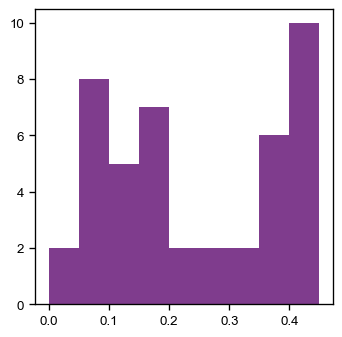

In [456]:
plt.hist(category_expression_results['abs_rank_dev'], bins = np.arange(0, 0.5, 0.05))

So that distribution _is_ slightly more bimodal than we expect. Kinda cool I guess?

# Try a noncoding example

The noncoding examples are... much harder. We expect them to have substantially less effect on expression compared to their coding counterparts.

I'm going to delete most of the text from the following code. It just follows the same as above.

In [457]:
nbl_noncoding_svs.head(2)

,SV,chrom,start,end,category,sv_category
0,PedSV.2.5.2_DUP_chr1_835,chr1,21344570,21344654,DUP.RARE.PREDICTED_NONCODING_BREAKPOINT.neurob...,non-coding
1,PedSV.2.5.2_DUP_chr1_898,chr1,23649481,23651544,DUP.RARE.PREDICTED_NONCODING_BREAKPOINT.neurob...,non-coding


In [458]:
# we'll select a non-tad framework for testing
nontad_test_framework = nbl_framework_results[(nbl_framework_results['af_category'] == "singleton") & 
                                              (nbl_framework_results['sv_category'] == "non-coding") &
                                              (~nbl_framework_results['category_name'].str.contains('tad'))].iloc[0]['category_name']

framework_components = nontad_test_framework.split(".")
genic_relationship = framework_components[2]
nontad_test_framework, genic_relationship

('ANY.SINGLETON.ANY.neuroblastoma_atac_peaks.ANY.ANY.ANY.protein_coding',
 'ANY')

In [459]:
nbl_framework_results.query('category_name == "ANY.SINGLETON.ANY.neuroblastoma_atac_peaks.ANY.ANY.ANY.protein_coding"')

,point_estimate,std_error,z_score,p_value,SV_counts_cases,SV_counts_cases_max,number_of_cases_with_zero_SVs,total_cases,SV_counts_controls,SV_counts_controls_max,number_of_controls_with_zero_SVs,total_controls,number_of_unique_SVs,category_name,sv_type,frequency,mean_SVs_per_case,mean_SVs_per_control,mean_SVs_total,negative_log10_p_value,af_category,sv_category
16,0.264388,0.058728,4.5019,0.000007,339,5,388,646,1950,5,3174,4698,359,ANY.SINGLETON.ANY.neuroblastoma_atac_peaks.ANY...,ANY,SINGLETON,0.524768,0.41507,0.428331,5.17167,singleton,non-coding


In [460]:
nbl_noncoding_framework.head(6)

,sv_type,frequency,functional_intersection,functional_category,genic_relationship,constraint,expression,gene_group
0,DUP,RARE,PREDICTED_NONCODING_BREAKPOINT,neuroblastoma_atac_peaks,PREDICTED_INTERGENIC,lof_constrained,expressed_in_adrenal_gland,protein_coding
1,DEL,SINGLETON,PREDICTED_NONCODING_SPAN,neuroblastoma_chromHMM15_Enh,PREDICTED_INTRONIC,ANY,ANY,cosmic_and_germline_CPGs
2,CPX_or_INV,NaN,ANY,neuroblastoma_chromHMM15_Enh_conserved,PREDICTED_PROMOTER,NaN,NaN,NaN
3,INS_ALL,NaN,NaN,neuroblastoma_chromHMM15_EnhG,PREDICTED_UTR,NaN,NaN,NaN
4,ANY,NaN,NaN,neuroblastoma_chromHMM15_EnhG_conserved,ANY,NaN,NaN,NaN
5,NaN,NaN,NaN,neuroblastoma_H3K27Ac_peak,NaN,NaN,NaN,NaN


In [461]:
genic_relationships = ['PREDICTED_INTERGENIC', 'PREDICTED_INTRONIC', 'PREDICTED_PROMOTER', 'PREDICTED_UTR']

# a weird feature of these data is that PREDICTED_INTERGENIC is actually boolean, and refers to PREDICTED_NEAREST_TSS
genic_relationships[genic_relationships.index('PREDICTED_INTERGENIC')] = 'PREDICTED_NEAREST_TSS'

In [462]:
svs_in_category = nbl_category_svs[(nbl_category_svs['sv_category'] == "non-coding") & 
                                   (nbl_category_svs["category"] == nontad_test_framework)]

# subset the actual SV matrix
svs_in_category = svs[svs["name"].isin(svs_in_category["SV"].tolist())]

svs_in_category.head(2)

,#chrom,start,end,name,svtype,AC,AF,ALGORITHMS,AN,BOTHSIDES_SUPPORT,CHR2,CNV_CONCORDANCE,CPX_INTERVALS,CPX_TYPE,END,END2,EVIDENCE,FAILED_COHORT_COMPARISONS,GENOTYPE_CONCORDANCE,HET_PPV,HET_SENSITIVITY,HG38_REF_PATCH_LOCUS,HIGH_SR_BACKGROUND,HOMVAR_PPV,HOMVAR_SENSITIVITY,MINSL,NCN,NCR,NCR_TMP,NON_REF_GENOTYPE_CONCORDANCE,OLD_ID,PCRMINUS_NCR,PESR_GT_OVERDISPERSION,PREDICTED_BREAKEND_EXONIC,PREDICTED_COPY_GAIN,PREDICTED_DUP_PARTIAL,PREDICTED_INTERGENIC,PREDICTED_INTRAGENIC_EXON_DUP,PREDICTED_INTRONIC,PREDICTED_INV_SPAN,PREDICTED_LOF,PREDICTED_MSV_EXON_OVERLAP,PREDICTED_NEAREST_TSS,PREDICTED_NONCODING_BREAKPOINT,PREDICTED_NONCODING_SPAN,PREDICTED_PARTIAL_EXON_DUP,PREDICTED_PROMOTER,PREDICTED_TSS_DUP,PREDICTED_UTR,SL_MAX,SL_MEAN,SOURCE,STATUS,STRANDS,SVLEN,SVTYPE,TRUTH_AC,TRUTH_AF,TRUTH_AN,TRUTH_VID,UNRESOLVED_TYPE,VAR_PPV,VAR_SENSITIVITY,VAR_SPECIFICITY,N_BI_GENOS,N_HOMREF,N_HET,N_HOMALT,FREQ_HOMREF,FREQ_HET,FREQ_HOMALT,CN_NUMBER,CN_COUNT,CN_FREQ,CN_NONREF_COUNT,CN_NONREF_FREQ,MALE_AN,MALE_AC,MALE_AF,MALE_N_BI_GENOS,MALE_N_HOMREF,MALE_N_HET,MALE_N_HOMALT,MALE_FREQ_HOMREF,MALE_FREQ_HET,MALE_FREQ_HOMALT,MALE_CN_NUMBER,MALE_CN_COUNT,MALE_CN_FREQ,MALE_CN_NONREF_COUNT,MALE_CN_NONREF_FREQ,MALE_N_HEMIREF,MALE_N_HEMIALT,MALE_FREQ_HEMIREF,MALE_FREQ_HEMIALT,FEMALE_AN,FEMALE_AC,FEMALE_AF,FEMALE_N_BI_GENOS,FEMALE_N_HOMREF,FEMALE_N_HET,FEMALE_N_HOMALT,FEMALE_FREQ_HOMREF,FEMALE_FREQ_HET,FEMALE_FREQ_HOMALT,FEMALE_CN_NUMBER,FEMALE_CN_COUNT,FEMALE_CN_FREQ,FEMALE_CN_NONREF_COUNT,FEMALE_CN_NONREF_FREQ,case_control_AFR_AN,case_control_AFR_AC,case_control_AFR_AF,case_control_AFR_N_BI_GENOS,case_control_AFR_N_HOMREF,case_control_AFR_N_HET,case_control_AFR_N_HOMALT,case_control_AFR_FREQ_HOMREF,case_control_AFR_FREQ_HET,case_control_AFR_FREQ_HOMALT,case_control_AFR_CN_NUMBER,case_control_AFR_CN_COUNT,case_control_AFR_CN_FREQ,case_control_AFR_CN_NONREF_COUNT,case_control_AFR_CN_NONREF_FREQ,case_control_AFR_MALE_AN,case_control_AFR_MALE_AC,case_control_AFR_MALE_AF,case_control_AFR_MALE_N_BI_GENOS,case_control_AFR_MALE_N_HOMREF,case_control_AFR_MALE_N_HET,case_control_AFR_MALE_N_HOMALT,case_control_AFR_MALE_FREQ_HOMREF,case_control_AFR_MALE_FREQ_HET,case_control_AFR_MALE_FREQ_HOMALT,case_control_AFR_MALE_CN_NUMBER,case_control_AFR_MALE_CN_COUNT,case_control_AFR_MALE_CN_FREQ,case_control_AFR_MALE_CN_NONREF_COUNT,case_control_AFR_MALE_CN_NONREF_FREQ,case_control_AFR_MALE_N_HEMIREF,case_control_AFR_MALE_N_HEMIALT,case_control_AFR_MALE_FREQ_HEMIREF,case_control_AFR_MALE_FREQ_HEMIALT,case_control_AFR_FEMALE_AN,case_control_AFR_FEMALE_AC,case_control_AFR_FEMALE_AF,case_control_AFR_FEMALE_N_BI_GENOS,case_control_AFR_FEMALE_N_HOMREF,case_control_AFR_FEMALE_N_HET,case_control_AFR_FEMALE_N_HOMALT,case_control_AFR_FEMALE_FREQ_HOMREF,case_control_AFR_FEMALE_FREQ_HET,case_control_AFR_FEMALE_FREQ_HOMALT,case_control_AFR_FEMALE_CN_NUMBER,case_control_AFR_FEMALE_CN_COUNT,case_control_AFR_FEMALE_CN_FREQ,case_control_AFR_FEMALE_CN_NONREF_COUNT,case_control_AFR_FEMALE_CN_NONREF_FREQ,case_control_AMR_AN,case_control_AMR_AC,case_control_AMR_AF,case_control_AMR_N_BI_GENOS,case_control_AMR_N_HOMREF,case_control_AMR_N_HET,case_control_AMR_N_HOMALT,case_control_AMR_FREQ_HOMREF,case_control_AMR_FREQ_HET,case_control_AMR_FREQ_HOMALT,case_control_AMR_CN_NUMBER,case_control_AMR_CN_COUNT,case_control_AMR_CN_FREQ,case_control_AMR_CN_NONREF_COUNT,case_control_AMR_CN_NONREF_FREQ,case_control_AMR_MALE_AN,case_control_AMR_MALE_AC,case_control_AMR_MALE_AF,case_control_AMR_MALE_N_BI_GENOS,case_control_AMR_MALE_N_HOMREF,case_control_AMR_MALE_N_HET,case_control_AMR_MALE_N_HOMALT,case_control_AMR_MALE_FREQ_HOMREF,case_control_AMR_MALE_FREQ_HET,case_control_AMR_MALE_FREQ_HOMALT,case_control_AMR_MALE_CN_NUMBER,case_control_AMR_MALE_CN_COUNT,case_control_AMR_MALE_CN_FREQ,case_control_AMR_MALE_CN_NONREF_COUNT,case_control_AMR_MALE_CN_NONREF_FREQ,case_control_AMR_MALE_N_HEMIREF,case_control_AMR_MALE_N_HEMIALT,case_control_AMR_MALE_FREQ_HEMIREF,case_control_AMR_MALE_FREQ_HEMIALT,case_control_AMR_FEMALE

In [463]:
svs_in_category.shape

(3021, 952)

In [464]:
svs_in_category[genic_relationships].head()

,PREDICTED_NEAREST_TSS,PREDICTED_INTRONIC,PREDICTED_PROMOTER,PREDICTED_UTR
120,NaN,NaN,C1orf159,NaN
137,TTLL10,NaN,NaN,NaN
224,NaN,ATAD3B,NaN,NaN
584,NaN,NaN,C1orf174,NaN
836,HES3,NaN,NaN,NaN


In [465]:
nbl_sv_dosages = (
    dosages
    .set_index("ID")
    .loc[svs_in_category["name"].tolist(), included_samples]
)
nbl_sv_dosages.head(2)

,PT_02SNWVRF,PT_11XN6CG5,PT_1396H6SD,PT_1EQHANKW,PT_1RH3DTPB,PT_1X6CJ589,PT_1X9YQF9W,PT_21PJ8R0Z,PT_26E4RFYV,PT_2JZNQGTR,PT_2QB9MP9J,PT_2RZN4HR2,PT_2Y7Q85BM,PT_3VNMNFT6,PT_4Y3P2N1P,PT_56ZM694R,PT_5E269C8Z,PT_5FCYBT0S,PT_69AGBVQ5,PT_6DHGCDRP,PT_6WE8JADD,PT_70BK6DFW,PT_7APMD0HG,PT_7BAFX5PZ,PT_7E6A5N3P,PT_81RSHW1D,PT_82D2FJV2,PT_8DFBAQVQ,PT_9A9Q2YB3,PT_9QQ37AWW,PT_9X3MV3GW,PT_A77B7F2F,PT_AGYJR7PZ,PT_AQS8CCAB,PT_ASJZTDRF,PT_ATQMV6B3,PT_B39849MF,PT_C3YC0C9Q,PT_D5BYDHZ9,PT_DCBZYQAX,PT_E3R0MRXN,PT_E6CZS2KF,PT_EXZSSRGH,PT_F0QD1YWQ,PT_F2AFSP66,PT_FZ3XEWEK,PT_GGJ9E0VV,PT_GSWXPFPQ,PT_HA7TBZ1V,PT_HB9JT4G5,PT_HYJB8Y4N,PT_HZ4VWQP5,PT_JBQT2QPG,PT_JD8FVX6G,PT_JYRSHSWJ,PT_K0BJPWY9,PT_K3QMVST1,PT_K579G3KQ,PT_KBVX8B37,PT_M4ETZ912,PT_M8RHAK5K,PT_MK375DCF,PT_NK39AFPG,PT_P111JVHP,PT_PDYCQB6P,PT_PFRE83H3,PT_PV869ZYE,PT_Q50YZ2T5,PT_QF2A2F08,PT_QH23VVKW,PT_R94DDN50,PT_RVTVP55V,PT_SBS3N6ZT,PT_SDPQ63J1,PT_SV8ETF29,PT_TTHE7B08,PT_V3BXBVVV,PT_V65ESGCE,PT_VVVS471N,PT_W6AVZF18,PT_WWRAC6EH,PT_X8N7GE8X,PT_XPTE7785,PT_YGW6KQHQ,PT_YMDFCE4V,PT_YS31MFW0,PT_Z4S0193A,PT_ZK8Z4WAK,PT_ZT2NW6WA
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PedSV.2.5.2_DEL_chr1_165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PedSV.2.5.2_DEL_chr1_186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [466]:
nbl_sv_dosages.shape

(3021, 89)

In [467]:
kept_svs = nbl_sv_dosages.fillna(0).sum(axis = 1) > 0
nbl_sv_dosages = nbl_sv_dosages.loc[kept_svs, :]

In [468]:
nbl_sv_dosages.shape

(48, 89)

In [471]:
genes_in_svs = svs_in_category.set_index('name').loc[nbl_sv_dosages.index, genic_relationships]
genes_in_svs.head(2)

,PREDICTED_NEAREST_TSS,PREDICTED_INTRONIC,PREDICTED_PROMOTER,PREDICTED_UTR
ID,,,,
PedSV.2.5.2_DEL_chr1_1438,ENO1,NaN,NaN,NaN
PedSV.2.5.2_DEL_chr1_2117,NaN,NaN,SPEN,NaN


In [472]:
tpms = merged_tpms.set_index('gene_id').loc[kept_gene_ids].set_index('gene_symbol').iloc[:, 1:]
tpms = tpms.loc[tpms.sum(axis = 1) > 0, :]
tpms.head(2)

sample,PT_02SNWVRF,PT_11XN6CG5,PT_1396H6SD,PT_1EQHANKW,PT_1RH3DTPB,PT_1X6CJ589,PT_1X9YQF9W,PT_21PJ8R0Z,PT_26E4RFYV,PT_2JZNQGTR,PT_2QB9MP9J,PT_2RZN4HR2,PT_2Y7Q85BM,PT_3VNMNFT6,PT_4Y3P2N1P,PT_56ZM694R,PT_5E269C8Z,PT_5FCYBT0S,PT_69AGBVQ5,PT_6DHGCDRP,PT_6WE8JADD,PT_70BK6DFW,PT_7APMD0HG,PT_7BAFX5PZ,PT_7E6A5N3P,PT_81RSHW1D,PT_82D2FJV2,PT_8DFBAQVQ,PT_9A9Q2YB3,PT_9QQ37AWW,PT_9X3MV3GW,PT_A77B7F2F,PT_AGYJR7PZ,PT_AQS8CCAB,PT_ASJZTDRF,PT_ATQMV6B3,PT_B39849MF,PT_C3YC0C9Q,PT_D5BYDHZ9,PT_DCBZYQAX,PT_E3R0MRXN,PT_E6CZS2KF,PT_EXZSSRGH,PT_F0QD1YWQ,PT_F2AFSP66,PT_FZ3XEWEK,PT_GGJ9E0VV,PT_GSWXPFPQ,PT_HA7TBZ1V,PT_HB9JT4G5,PT_HYJB8Y4N,PT_HZ4VWQP5,PT_JBQT2QPG,PT_JD8FVX6G,PT_JYRSHSWJ,PT_K0BJPWY9,PT_K3QMVST1,PT_K579G3KQ,PT_KBVX8B37,PT_M4ETZ912,PT_M8RHAK5K,PT_MK375DCF,PT_NK39AFPG,PT_P111JVHP,PT_PDYCQB6P,PT_PFRE83H3,PT_PV869ZYE,PT_Q50YZ2T5,PT_QF2A2F08,PT_QH23VVKW,PT_R94DDN50,PT_RVTVP55V,PT_SBS3N6ZT,PT_SDPQ63J1,PT_SV8ETF29,PT_TTHE7B08,PT_V3BXBVVV,PT_V65ESGCE,PT_VVVS471N,PT_W6AVZF18,PT_WWRAC6EH,PT_X8N7GE8X,PT_XPTE7785,PT_YGW6KQHQ,PT_YMDFCE4V,PT_YS31MFW0,PT_Z4S0193A,PT_ZK8Z4WAK,PT_ZT2NW6WA
gene_symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TSPAN6,3.61,2.15,5.05,9.24,1.38,4.27,2.02,3.17,5.85,6.36,3.48,3.11,2.27,5.13,4.91,5.14,9.19,4.50,2.19,5.56,2.22,3.48,12.82,3.93,5.42,15.09,6.02,7.13,5.19,3.77,15.50,2.43,2.27,2.85,3.30,11.01,3.75,4.35,6.82,8.82,5.47,6.03,13.90,4.05,3.34,10.79,4.17,4.58,5.50,3.37,5.51,9.22,5.25,6.79,9.47,3.72,7.45,2.37,7.13,7.82,4.77,5.72,6.19,1.63,6.56,3.98,4.65,3.64,2.78,3.71,16.48,19.99,4.63,4.94,4.78,2.71,7.36,2.39,2.21,3.59,5.76,4.59,13.63,5.41,2.71,5.58,4.73,13.37,10.42
DPM1,6.62,7.87,9.53,6.47,8.50,8.60,4.42,14.89,6.82,8.34,11.18,6.19,14.00,9.55,10.03,10.89,7.57,10.69,16.08,9.30,8.82,6.57,8.18,8.04,6.04,10.48,10.56,6.59,9.23,9.81,7.94,6.79,13.07,11.07,15.11,8.91,16.16,7.94,6.96,8.88,7.65,8.60,12.84,7.12,4.40,5.96,6.23,9.24,8.51,4.64,9.08,7.29,9.21,12.98,8.29,6.15,12.28,11.06,4.80,9.61,7.01,7.17,8.40,8.62,9.24,10.62,8.02,8.32,11.61,7.05,11.15,10.57,7.43,9.57,9.12,6.07,7.61,9.08,7.77,6.19,9.14,10.08,11.38,5.59,7.46,4.74,8.39,6.96,10.87


In [473]:
category_expression_results = []
for sv_name, row in genes_in_svs.iterrows():
    
    # get the dosage of the SV
    sv_dosages = nbl_sv_dosages.loc[sv_name]
    
    # drop samples that aren't genotyped
    sv_dosages = sv_dosages.dropna()
    
    # get the samples with the SV
    samples_with_sv = sv_dosages[sv_dosages > 0].index
    
    for col in genic_relationships:
        if pd.isnull(row[col]):
            continue
            
        for gene in row[col].split(','):
            if gene not in list(tpms.index):
                print(gene + ' not in TPMs')
                continue
            
            # get the expression values
            gene_expression = tpms.loc[gene, sv_dosages.index]
            
            # handle gene name duplicates. Choose the one that is more expressed.
            if len(gene_expression.shape) > 1:
                sorted_values = tpms.loc[gene, sv_dosages.index].mean(axis = 1)
                gene_expression = gene_expression.iloc[np.argmax(sorted_values), :]
                
            # calculate an average expression for qc later
            avg_expression = np.mean(gene_expression)
                
            # now rank the expression of the genes and look up the ranks of the
            # samples with SVs
            ranked_expression = np.argsort(np.argsort(gene_expression)[::-1])
            sv_ranks = ranked_expression.loc[samples_with_sv]
            
            # get the average SV rank (to handle multiple samples with the SV, uncommon)
            average_sv_rank = sv_ranks.mean() / len(sv_dosages)
            
            # store our data
            storage_row = [col, gene, avg_expression, average_sv_rank]
            category_expression_results.append(storage_row)
            
category_expression_results = pd.DataFrame(category_expression_results, columns = ['genic_relationship', 'gene', 'mean_exp', 'mean_rank_of_sample_w_sv'])

GJE1 not in TPMs
AGR3 not in TPMs
TPD52L3 not in TPMs
NALF1 not in TPMs
APOC4 not in TPMs


In [474]:
category_expression_results['mean_rank_of_sample_w_sv'].mean()

0.6062251113918187

This _is_ a significant result. Kind of interesting. Let's account for directionality.

In [475]:
category_expression_results['abs_rank_dev'] = np.abs(0.5 - category_expression_results['mean_rank_of_sample_w_sv'])

In [476]:
category_expression_results['abs_rank_dev'].mean()

0.25467994395517835

Interesting... this _is_ not a significant result. Kind of begs the question how this is possible?

(array([4., 2., 4., 6., 4., 4., 8., 5., 0.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]),
 <BarContainer object of 9 artists>)

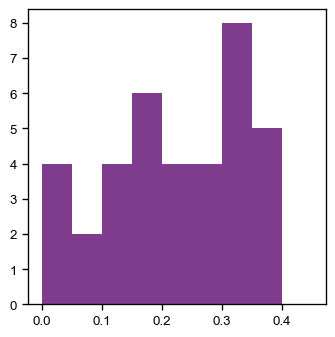

In [477]:
plt.hist(category_expression_results['abs_rank_dev'], bins = np.arange(0, 0.5, 0.05))

# Generalize

Alright, here we go. This is going to be a bit complicated, but it shouldn't be difficult.

In [478]:
nbl_analysis_categories = nbl_framework_results.query('negative_log10_p_value > 3.5')
nbl_analysis_categories.shape

(77, 22)

In [480]:
gr_coding_mapping = {'PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP': ['PREDICTED_LOF', 'PREDICTED_PARTIAL_EXON_DUP'],
                     'ANY': ['PREDICTED_COPY_GAIN', 'PREDICTED_INTRAGENIC_EXON_DUP', 'PREDICTED_LOF', 'PREDICTED_PARTIAL_EXON_DUP']}

gr_noncoding_mapping = {'ANY': ['PREDICTED_INTERGENIC', 'PREDICTED_INTRONIC', 'PREDICTED_PROMOTER', 'PREDICTED_UTR']}


In [481]:
tpms = merged_tpms.set_index('gene_id').loc[kept_gene_ids].set_index('gene_symbol').iloc[:, 1:]
tpms = tpms.loc[tpms.sum(axis = 1) > 0, :]
tpms.head(2)

sample,PT_02SNWVRF,PT_11XN6CG5,PT_1396H6SD,PT_1EQHANKW,PT_1RH3DTPB,PT_1X6CJ589,PT_1X9YQF9W,PT_21PJ8R0Z,PT_26E4RFYV,PT_2JZNQGTR,PT_2QB9MP9J,PT_2RZN4HR2,PT_2Y7Q85BM,PT_3VNMNFT6,PT_4Y3P2N1P,PT_56ZM694R,PT_5E269C8Z,PT_5FCYBT0S,PT_69AGBVQ5,PT_6DHGCDRP,PT_6WE8JADD,PT_70BK6DFW,PT_7APMD0HG,PT_7BAFX5PZ,PT_7E6A5N3P,PT_81RSHW1D,PT_82D2FJV2,PT_8DFBAQVQ,PT_9A9Q2YB3,PT_9QQ37AWW,PT_9X3MV3GW,PT_A77B7F2F,PT_AGYJR7PZ,PT_AQS8CCAB,PT_ASJZTDRF,PT_ATQMV6B3,PT_B39849MF,PT_C3YC0C9Q,PT_D5BYDHZ9,PT_DCBZYQAX,PT_E3R0MRXN,PT_E6CZS2KF,PT_EXZSSRGH,PT_F0QD1YWQ,PT_F2AFSP66,PT_FZ3XEWEK,PT_GGJ9E0VV,PT_GSWXPFPQ,PT_HA7TBZ1V,PT_HB9JT4G5,PT_HYJB8Y4N,PT_HZ4VWQP5,PT_JBQT2QPG,PT_JD8FVX6G,PT_JYRSHSWJ,PT_K0BJPWY9,PT_K3QMVST1,PT_K579G3KQ,PT_KBVX8B37,PT_M4ETZ912,PT_M8RHAK5K,PT_MK375DCF,PT_NK39AFPG,PT_P111JVHP,PT_PDYCQB6P,PT_PFRE83H3,PT_PV869ZYE,PT_Q50YZ2T5,PT_QF2A2F08,PT_QH23VVKW,PT_R94DDN50,PT_RVTVP55V,PT_SBS3N6ZT,PT_SDPQ63J1,PT_SV8ETF29,PT_TTHE7B08,PT_V3BXBVVV,PT_V65ESGCE,PT_VVVS471N,PT_W6AVZF18,PT_WWRAC6EH,PT_X8N7GE8X,PT_XPTE7785,PT_YGW6KQHQ,PT_YMDFCE4V,PT_YS31MFW0,PT_Z4S0193A,PT_ZK8Z4WAK,PT_ZT2NW6WA
gene_symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TSPAN6,3.61,2.15,5.05,9.24,1.38,4.27,2.02,3.17,5.85,6.36,3.48,3.11,2.27,5.13,4.91,5.14,9.19,4.50,2.19,5.56,2.22,3.48,12.82,3.93,5.42,15.09,6.02,7.13,5.19,3.77,15.50,2.43,2.27,2.85,3.30,11.01,3.75,4.35,6.82,8.82,5.47,6.03,13.90,4.05,3.34,10.79,4.17,4.58,5.50,3.37,5.51,9.22,5.25,6.79,9.47,3.72,7.45,2.37,7.13,7.82,4.77,5.72,6.19,1.63,6.56,3.98,4.65,3.64,2.78,3.71,16.48,19.99,4.63,4.94,4.78,2.71,7.36,2.39,2.21,3.59,5.76,4.59,13.63,5.41,2.71,5.58,4.73,13.37,10.42
DPM1,6.62,7.87,9.53,6.47,8.50,8.60,4.42,14.89,6.82,8.34,11.18,6.19,14.00,9.55,10.03,10.89,7.57,10.69,16.08,9.30,8.82,6.57,8.18,8.04,6.04,10.48,10.56,6.59,9.23,9.81,7.94,6.79,13.07,11.07,15.11,8.91,16.16,7.94,6.96,8.88,7.65,8.60,12.84,7.12,4.40,5.96,6.23,9.24,8.51,4.64,9.08,7.29,9.21,12.98,8.29,6.15,12.28,11.06,4.80,9.61,7.01,7.17,8.40,8.62,9.24,10.62,8.02,8.32,11.61,7.05,11.15,10.57,7.43,9.57,9.12,6.07,7.61,9.08,7.77,6.19,9.14,10.08,11.38,5.59,7.46,4.74,8.39,6.96,10.87


In [492]:
expression_results = []
sv_gene_results = []

for i, (index, row) in enumerate(nbl_analysis_categories.iterrows()):
    print(i, end = ', ')
    cat_name = row['category_name']
    af_category = row['af_category']
    sv_category = row['sv_category']
    p_category = row['p_value']
    
    cat_components = cat_name.split('.')
    
    base_row = [cat_name, af_category, sv_category, p_category]
    
    # here, we define the necessary genic relationships
    # we handle the collapsed categories as well
    if sv_category == 'coding':
        gr = cat_components[2]

        # convert gr to components
        genic_rel = gr_coding_mapping.get(gr, [gr])
        
    elif sv_category == 'non-coding':
        gr = cat_components[4]

        # convert gr to components
        genic_rel = gr_noncoding_mapping.get(gr, [gr])
        
    # swap out intergenic for nearest_tss
    if 'PREDICTED_INTERGENIC' in genic_rel:
        genic_rel[genic_rel.index('PREDICTED_INTERGENIC')] = 'PREDICTED_NEAREST_TSS'
        
    # next, we pull out our SVs in this category
    svs_in_category = nbl_category_svs[(nbl_category_svs['sv_category'] == sv_category) & 
                                       (nbl_category_svs["category"] == cat_name)]
    
    # subset the actual SV matrix
    svs_in_category = svs[svs["name"].isin(svs_in_category["SV"].tolist())]
    
    # extract the dosages
    nbl_sv_dosages = (
        dosages
        .set_index("ID")
        .loc[svs_in_category["name"].tolist(), included_samples]
        )
    
    # drop SVs with no counts
    kept_svs = nbl_sv_dosages.fillna(0).sum(axis = 1) > 0
    nbl_sv_dosages = nbl_sv_dosages.loc[kept_svs, :]
    
    if len(nbl_sv_dosages) == 0:
        print(cat_name, ' has no RNA samples with the SV')
        continue
    
    # define our genes
    genes_in_svs = svs_in_category.set_index('name').loc[nbl_sv_dosages.index, genic_rel]
    
    category_exp_results = []
    for sv_name, row in genes_in_svs.iterrows():
        
        # get the dosage of the SV
        sv_dosages = nbl_sv_dosages.loc[sv_name]
        sv_dosages = sv_dosages.dropna()
        
        # get the samples with the SV
        samples_with_sv = sv_dosages[sv_dosages > 0].index
        
        # loop through an examine the genes
        for col in genic_rel:
            if pd.isnull(row[col]):
                continue
            
            for gene in row[col].split(','):
                if gene not in list(tpms.index):
                    continue
                    
                # get the expression values
                gene_expression = tpms.loc[gene, sv_dosages.index]
                
                # handle gene name duplicates. Choose the one that is more expressed.
                if len(gene_expression.shape) > 1:
                    sorted_values = tpms.loc[gene, sv_dosages.index].mean(axis = 1)
                    gene_expression = gene_expression.iloc[np.argmax(sorted_values), :]
                    
                # calculate an average expression for qc later
                avg_expression = np.mean(gene_expression)

                # now rank the expression of the genes and look up the ranks of the
                # samples with SVs
                ranked_expression = np.argsort(np.argsort(gene_expression)[::-1])
                sv_ranks = ranked_expression.loc[samples_with_sv]
                
                # get the average SV rank (to handle multiple samples with the SV, uncommon)
                average_sv_rank = sv_ranks.mean() / len(sv_dosages)

                # store our data
                storage_row = base_row + [sv_name, col, gene, avg_expression, average_sv_rank]
                category_exp_results.append(storage_row)
                sv_gene_results.append(storage_row)
                
    # calculate the average absolute and deviation rank
    temp = pd.DataFrame(category_exp_results)
    mean_abs_rank = np.mean(temp.iloc[:, -1])
    mean_dev_rank = np.mean(np.abs(0.5 - temp.iloc[:, -1]))
    num_genes = temp.shape[0]
    
    total_storage_row = base_row + [num_genes, mean_abs_rank, mean_dev_rank]
    expression_results.append(total_storage_row)
    
fine_result_names = ['category', 'af_category', 'sv_category', 'category_p', 'sv_name', 'genic_rel', 'gene', 'avg_exp', 'sv_rank']
sv_gene_results = pd.DataFrame(sv_gene_results, columns = fine_result_names)

broad_result_names = ['category', 'af_category', 'sv_category', 'category_p', 'num_svs', 'mean_abs_rank', 'mean_dev_rank']
expression_results = pd.DataFrame(expression_results, columns = broad_result_names)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, DEL.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary_conserved.ANY.ANY.ANY.cosmic_and_germline_CPGs  has no RNA samples with the SV
40, DEL.SINGLETON.ANY.neuroblastoma_tad_boundary_conserved.ANY.ANY.ANY.cosmic_and_germline_CPGs  has no RNA samples with the SV
41, 42, 43, 44, 45, 46, 47, 48, 49, ANY.RARE.PREDICTED_NONCODING_SPAN.neuroblastoma_chromHMM15_EnhBiv.PREDICTED_INTRONIC.lof_constrained.ANY.protein_coding  has no RNA samples with the SV
50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 

# Derive a distribution for the deviation from rank

In [305]:
dev_storage = []
for i in range(100000):
    test = np.random.uniform(3, size = (63, 89))
    rank_storage = []
    for j in range(63):
        data = test[j, :]
        ranks = np.argsort(np.argsort(data)[::-1]) / len(data)
        rank_storage.append(ranks[0])
        
    rank_storage = np.array(rank_storage)
    dev_storage.append(np.abs(0.5 - rank_storage))